In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
stations_df = pd.read_csv('Resources/hawaii_stations.csv')
measurements_df = pd.read_csv('Resources/hawaii_measurements.csv')
# load the dataframe into the in-memory sqlite db
stations_df.to_sql('stations', engine, if_exists='replace')
measurements_df.to_sql('measurements', engine, if_exists='replace')

# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date
print(most_recent_date)

2017-08-23


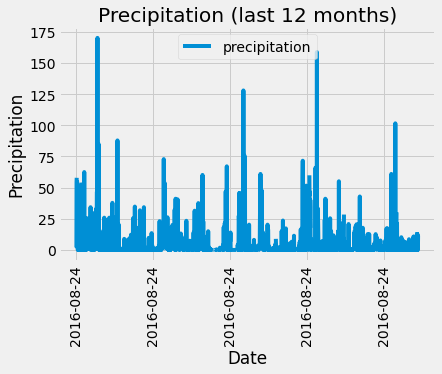

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set
last_year_date = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Set the index to the date column
precipitation_df.set_index('date', inplace=True)

# Sort the dataframe by date
precipitation_df.sort_index(inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots()
precipitation_df.plot(ax=ax, title="Precipitation (last 12 months)")
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
ax.set_xticklabels(precipitation_df.index, rotation=90)
plt.show()

In [11]:
# Use Pandas to calcualte the summary statistics for the precipitation data
print(precipitation_df.describe())

       precipitation
count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.id)).scalar()
print(total_stations)

9


In [13]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print(most_active_stations)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
average_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
print(f"Lowest temperature: {lowest_temp}")
print(f"Highest temperature: {highest_temp}")
print(f"Average temperature: {average_temp}")

Lowest temperature: 12.2
Highest temperature: 29.4
Average temperature: 22.03582251082252


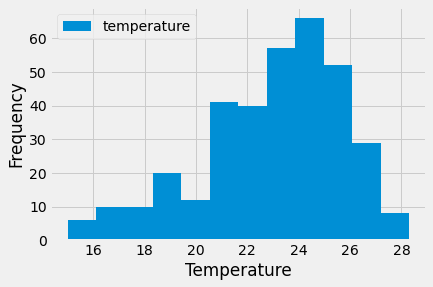

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# Calculate the date one year from the last date in data set
last_year_date = datetime.strptime(most_recent_date, '%Y-%m-%d') - timedelta(days=365)

# Perform a query to retrieve the data and temperature scores
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= last_year_date).\
    filter(Measurement.station == most_active_station).\
    order_by(Measurement.date).all()

# Plot the temperature data as a histogram
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])
temperature_df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()

# Close session

In [16]:
# Close Session
session.close()